Code for papers:
1) Forgetting Outside the Box: Scrubbing Deep Networks of Information Accessible from Input-Output Observations (https://arxiv.org/abs/2003.02960) <br>
2) Eternal Sunshine of the Spotless Net : Selective forgetting in Deep Networks (https://arxiv.org/abs/1911.04933)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *

/home/aditya/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def pdb():
    import pdb
    pdb.set_trace

In [3]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')

In [4]:
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

In [5]:
def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

### Pre-training

In [6]:
#%run main.py --dataset lacuna100 --model allcnn --filters 1.0 --lr 0.1 --lossfn ce --num-classes 100

### Fine-tuning

In [150]:
%run main.py --dataset small_cifar5 --model resnet --filters 0.4 --lr 0.01\
--resume checkpoints/cifar100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_25.pt --disable-bn\
--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 1

Checkpoint name: small_cifar5_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1
[Logging in small_cifar5_resnet_0_4_forget_None_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Number of Classes: 5
[0] train metrics:{"loss": 1.7039970436096192, "error": 0.7780000026226044}
Learning Rate : 0.01
[0] test metrics:{"loss": 1.4608981723785401, "error": 0.6460000026226044}
Learning Rate : 0.01
Epoch Time: 0.48 sec
[1] train metrics:{"loss": 1.3020475568771361, "error": 0.5219999997615814}
Learning Rate : 0.01
Epoch Time: 0.27 sec
[2] train metrics:{"loss": 0.9928716106414794, "error": 0.3160000019073486}
Learning Rate : 0.01
Epoch Time: 0.27 sec
[3] train metrics:{"loss": 0.8012013492584229, "error": 0.24000000524520873}
Learning Rate : 0.01
Epoch Time: 0.36 sec
[4] train metrics:{"loss": 0.6915865902900695, "error": 0.2119999957084656}
Learning Rate : 0.01
Epoch Time: 0.32 sec
[5] train metrics:{"loss": 0.632978

In [151]:
%run main.py --dataset small_cifar5 --model resnet --filters 0.4 --lr 0.01\
--resume checkpoints/cifar100_resnet_0_4_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_25.pt --disable-bn\
--weight-decay 0.1 --batch-size 128 --epochs 31\
--forget-class 0 --num-to-forget 25 --seed 1

Checkpoint name: small_cifar5_resnet_0_4_forget_0_num_25_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1
[Logging in small_cifar5_resnet_0_4_forget_0_num_25_lr_0_01_bs_128_ls_ce_wd_0_1_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45]
Number of Classes: 5
[0] train metrics:{"loss": 1.6633460474014283, "error": 0.7600000004768371}
Learning Rate : 0.01
[0] test metrics:{"loss": 1.4610265054702758, "error": 0.6440000002384185}
Learning Rate : 0.01
Epoch Time: 0.33 sec
[1] train metrics:{"loss": 1.2611491651535034, "error": 0.5060000023841857}
Learning Rate : 0.01
Epoch Time: 0.24 sec
[2] train metrics:{"loss": 0.9654477944374085, "error": 0.33000000619888303}
Learning Rate : 0.01
Epoch Time: 0.27 sec
[3] train metrics:{"loss": 0.7829683752059936, "error": 0.23600000047683717}
Learning Rate : 0.01
Epoch Time: 0.36 sec
[4] train metrics:{"loss": 0.6663924803733826, "

#### Logs

In [152]:
log_dict={}
training_epochs=25

In [153]:
log_dict['epoch']=training_epochs

In [154]:
parameter_count(copy.deepcopy(model))

Total Number of Parameters: 1787741


### Loads checkpoints

In [155]:
import copy
model0 = copy.deepcopy(model)

arch = args.model 
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - num_to_forget
seed = args.seed
unfreeze_start = None

learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load(m_name))
model0.load_state_dict(torch.load(m0_name))

model.cuda()
model0.cuda()

for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

In [156]:
log_dict['args']=args

### Distance between w(D) and w(D_r)

In [157]:
def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [158]:
log_dict['dist_Original_Retrain']=distance(model,model0)

Distance: 0.4293469691461159
Normalized Distance: 0.0048218586950619195


### Distance of w(D) from initialization

In [159]:
def ntk_init(resume,seed=1):
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args.device)
    model_init.load_state_dict(torch.load(resume))
    return model_init

In [160]:
model_init = ntk_init(init_checkpoint,args.seed)
for p in model_init.parameters():
    p.data0 = p.data.clone()

In [161]:
log_dict['dist_Original_Original_init']=distance(model_init,model)

Distance: 1.9694975157670922
Normalized Distance: 0.022144503782409307


#### Data Loader

In [162]:
train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=args.batch_size, seed=seed, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Replacing indexes [26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45]


# NTK based Forgetting

#### NTK Update

In [163]:
def delta_w_utils(model_init,dataloader,name='complete'):
    model_init.eval()
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    G_list = []
    f0_minus_y = []
    for idx, batch in enumerate(dataloader):#(tqdm(dataloader,leave=False)):
        batch = [tensor.to(next(model_init.parameters()).device) for tensor in batch]
        input, target = batch
        if 'mnist' in args.dataset:
            input = input.view(input.shape[0],-1)
        target = target.cpu().detach().numpy()
        output = model_init(input)
        G_sample=[]
        for cls in range(num_classes):
            grads = torch.autograd.grad(output[0,cls],model_init.parameters(),retain_graph=True)
            grads = np.concatenate([g.view(-1).cpu().numpy() for g in grads])
            G_sample.append(grads)
            G_list.append(grads)
        if args.lossfn=='mse':
            p = output.cpu().detach().numpy().transpose()
            #loss_hess = np.eye(len(p))
            target = 2*target-1
            f0_y_update = p-target
        elif args.lossfn=='ce':
            p = torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().transpose()
            p[target]-=1
            f0_y_update = copy.deepcopy(p)
        f0_minus_y.append(f0_y_update)
    return np.stack(G_list).transpose(),np.vstack(f0_minus_y)

#### Jacobians and Hessians

In [164]:
model_init = ntk_init(init_checkpoint,args.seed)
G_r,f0_minus_y_r = delta_w_utils(copy.deepcopy(model),retain_loader,'complete') 

np.save('NTK_data/G_r.npy',G_r)
np.save('NTK_data/f0_minus_y_r.npy',f0_minus_y_r)
del G_r, f0_minus_y_r

model_init = ntk_init(init_checkpoint,args.seed)
G_f,f0_minus_y_f = delta_w_utils(copy.deepcopy(model),forget_loader,'retain') 

np.save('NTK_data/G_f.npy',G_f)
np.save('NTK_data/f0_minus_y_f.npy',f0_minus_y_f)
del G_f, f0_minus_y_f

In [165]:
G_r = np.load('NTK_data/G_r.npy')
G_f = np.load('NTK_data/G_f.npy')
G = np.concatenate([G_r,G_f],axis=1)

np.save('NTK_data/G.npy',G)
del G, G_f, G_r

f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')
f0_minus_y_f = np.load('NTK_data/f0_minus_y_f.npy')
f0_minus_y = np.concatenate([f0_minus_y_r,f0_minus_y_f])

np.save('NTK_data/f0_minus_y.npy',f0_minus_y)
del f0_minus_y, f0_minus_y_r, f0_minus_y_f

This only requires access to the gradients and the initialization

### w_lin(D)

In [166]:
G = np.load('NTK_data/G.npy')
theta = G.transpose().dot(G) + num_total*args.weight_decay*np.eye(G.shape[1])
del G

theta_inv = np.linalg.inv(theta)

np.save('NTK_data/theta.npy',theta)
del theta

G = np.load('NTK_data/G.npy')
f0_minus_y = np.load('NTK_data/f0_minus_y.npy')
w_complete = -G.dot(theta_inv.dot(f0_minus_y))

np.save('NTK_data/theta_inv.npy',theta_inv)
np.save('NTK_data/w_complete.npy',w_complete)
del G, f0_minus_y, theta_inv, w_complete 

### w_lin(D_r)

In [167]:
G_r = np.load('NTK_data/G_r.npy')
theta_r = G_r.transpose().dot(G_r) + num_to_retain*args.weight_decay*np.eye(G_r.shape[1])
del G_r

theta_r_inv = np.linalg.inv(theta_r)
np.save('NTK_data/theta_r.npy',theta_r)
del theta_r

G_r = np.load('NTK_data/G_r.npy')
f0_minus_y_r = np.load('NTK_data/f0_minus_y_r.npy')
w_retain = -G_r.dot(theta_r_inv.dot(f0_minus_y_r))

np.save('NTK_data/theta_r_inv.npy',theta_r_inv)
np.save('NTK_data/w_retain.npy',w_retain)
del G_r, f0_minus_y_r, theta_r_inv, w_retain 

#### Scrubbing Direction

In [168]:
#### Scrubbing Direction
w_complete = np.load('NTK_data/w_complete.npy')
w_retain = np.load('NTK_data/w_retain.npy')
delta_w = (w_retain-w_complete).squeeze()

In [169]:
delta_w_copy = copy.deepcopy(delta_w)

#### Actual Change in Weights

In [170]:
delta_w_actual = vectorize_params(model0)-vectorize_params(model)

print(f'Actual Norm-: {np.linalg.norm(delta_w_actual)}')
print(f'Predtn Norm-: {np.linalg.norm(delta_w)}')
scale_ratio = np.linalg.norm(delta_w_actual)/np.linalg.norm(delta_w)
print('Actual Scale: {}'.format(scale_ratio))
log_dict['actual_scale_ratio']=scale_ratio

Actual Norm-: 0.4293469786643982
Predtn Norm-: 0.01818803805860664
Actual Scale: 23.606008371047462


#### Trapezium Trick

In [171]:
m_pred_error = vectorize_params(model)-vectorize_params(model_init)-w_retain.squeeze()
print(f"Delta w -------: {np.linalg.norm(delta_w)}")

inner = np.inner(delta_w/np.linalg.norm(delta_w),m_pred_error/np.linalg.norm(m_pred_error))
print(f"Inner Product--: {inner}")

if inner<0:
    angle = np.arccos(inner)-np.pi/2
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.sin(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")
else:
    angle = np.arccos(inner) 
    print(f"Angle----------:  {angle}")

    predicted_norm=np.linalg.norm(delta_w) + 2*np.cos(angle)*np.linalg.norm(m_pred_error)
    print(f"Pred Act Norm--:  {predicted_norm}")

predicted_scale=predicted_norm/np.linalg.norm(delta_w)
predicted_scale
print(f"Predicted Scale:  {predicted_scale}")
log_dict['predicted_scale_ratio']=predicted_scale

Delta w -------: 0.01818803805860664
Inner Product--: -0.10559447380659286
Angle----------:  0.1057916981335798
Pred Act Norm--:  0.4281945332803079
Predicted Scale:  23.542645550913875


#### Normalized Inner Product between Prediction and Actual Scrubbing Update

In [172]:
def NIP(v1,v2):
    nip = (np.inner(v1/np.linalg.norm(v1),v2/np.linalg.norm(v2)))
    print(nip)
    return nip

In [173]:
nip=NIP(delta_w_actual,delta_w)
log_dict['nip']=nip

0.49541777628094164


#### Reshape delta_w

In [174]:
def get_delta_w_dict(delta_w,model):
    # Give normalized delta_w
    delta_w_dict = OrderedDict()
    params_visited = 0
    for k,p in model.named_parameters():
        num_params = np.prod(list(p.shape))
        update_params = delta_w[params_visited:params_visited+num_params]
        delta_w_dict[k] = torch.Tensor(update_params).view_as(p)
        params_visited+=num_params
    return delta_w_dict

### Metrics

In [175]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [176]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']
    return activations,predictions

In [177]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [178]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

### Original Model

In [179]:
m_D_r_activations,m_D_r_predictions=activations_predictions(model,retain_loader,'Original_Model_D_r')
m_D_f_activations,m_D_f_predictions=activations_predictions(model,forget_loader,'Original_Model_D_f')
m_D_t_activations,m_D_t_predictions=activations_predictions(model,test_loader_full,'Original_Model_D_t')

Original_Model_D_r -> Loss:0.046, Error:0.0
Original_Model_D_f -> Loss:0.072, Error:0.0
Original_Model_D_t -> Loss:0.749, Error:0.24


### Retrain Model

In [180]:
m0_D_r_activations,m0_D_r_predictions=activations_predictions(model0,retain_loader,'Retrain_Model_D_r')
m0_D_f_activations,m0_D_f_predictions=activations_predictions(model0,forget_loader,'Retrain_Model_D_f')
m0_D_t_activations,m0_D_t_predictions=activations_predictions(model0,test_loader_full,'Retrain_Model_D_t')

Retrain_Model_D_r -> Loss:0.047, Error:0.0
Retrain_Model_D_f -> Loss:1.195, Error:0.36
Retrain_Model_D_t -> Loss:0.771, Error:0.256


# Scrub using NTK

In [181]:
scale=predicted_scale
direction = get_delta_w_dict(delta_w,model)

model_scrub = copy.deepcopy(model)
for k,p in model_scrub.named_parameters():
    p.data += (direction[k]*scale).to(args.device)

In [182]:
ntk_D_r_activations,ntk_D_r_predictions=activations_predictions(model_scrub,retain_loader,'NTK_D_r')
ntk_D_f_activations,ntk_D_f_predictions=activations_predictions(model_scrub,forget_loader,'NTK_D_f')
ntk_D_t_activations,ntk_D_t_predictions=activations_predictions(model_scrub,test_loader_full,'NTK_D_t')

NTK_D_r -> Loss:0.046, Error:0.0
NTK_D_f -> Loss:0.928, Error:0.28
NTK_D_t -> Loss:0.754, Error:0.254


In [183]:
predictions_distance(m0_D_f_predictions,m_D_f_predictions,'Retrain_Original_D_f')
predictions_distance(m0_D_f_predictions,ntk_D_f_predictions,'Retrain_NTK_D_f')

Predictions Distance Retrain_Original_D_f -> 9.0
Predictions Distance Retrain_NTK_D_f -> 2.0


### Activations Distance

In [184]:
activations_distance(m0_D_f_activations,m_D_f_activations,'Retrain_Original_D_f')
activations_distance(m0_D_r_activations,m_D_r_activations,'Retrain_Original_D_r')
activations_distance(m0_D_t_activations,m_D_t_activations,'Retrain_Original_D_t')
activations_distance(m0_D_f_activations,ntk_D_f_activations,'Retrain_NTK_D_f')
activations_distance(m0_D_r_activations,ntk_D_r_activations,'Retrain_NTK_D_r')
activations_distance(m0_D_t_activations,ntk_D_t_activations,'Retrain_NTK_D_t')

Activations Distance Retrain_Original_D_f -> 0.7483457326889038
Activations Distance Retrain_Original_D_r -> 0.011976897716522217
Activations Distance Retrain_Original_D_t -> 0.08279383927583694
Activations Distance Retrain_NTK_D_f -> 0.233624666929245
Activations Distance Retrain_NTK_D_r -> 0.011692313477396965
Activations Distance Retrain_NTK_D_t -> 0.06863094866275787


# Fisher Forgetting

### Finetune and Fisher Helper

In [185]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [186]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [187]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)

def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [188]:
def readout_retrain(model, data_loader, test_loader, lr=0.01, epochs=100, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method'):
    train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=args.batch_size, shuffle=True)
    retrain_time, _ = readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.01, threshold=thresh)
    test_error = test(model, test_loader_full)['error']
    forget_error = test(model, forget_loader)['error']
    retain_error = test(model, retain_loader)['error']
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2%}"
          f"\tForget error: {forget_error:.2%}\tRetain error: {retain_error:.2%}"
          f"\tFine-tune time: {retrain_time+1} steps")
    log_dict[f"{name}_retrain_time"]=retrain_time+1
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, retrain_time=retrain_time))

# Fisher

In [189]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [190]:
def hessian(dataset, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(args.device), orig_target.to(args.device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [191]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

In [192]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    if p.size(0) == num_classes and num_to_forget is None:
        mu[class_to_forget] = 0
        var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

## Fisher Noise in Weights

In [249]:
# Computes the amount of information not forgotten at all layers using the given alpha
alpha = 1e-6
total_kl = 0
torch.manual_seed(seed)
for (k, p), (k0, p0) in zip(modelf.named_parameters(), modelf0.named_parameters()):
    mu0, var0 = get_mean_var(p, False, alpha=alpha)
    mu1, var1 = get_mean_var(p0, True, alpha=alpha)
    kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
    total_kl += kl
    print(k, f'{kl:.1f}')
print("Total:", total_kl)
log_dict['fisher_info']=total_kl

conv1.weight 4.6
conv1.bias 0.0
bn1.weight 0.5
bn1.bias 0.2
layer1.0.bn1.weight 0.1
layer1.0.bn1.bias 0.0
layer1.0.conv1.weight 1.6
layer1.0.conv1.bias 0.0
layer1.0.bn2.weight 0.1
layer1.0.bn2.bias 0.0
layer1.0.conv2.weight 1.6
layer1.0.conv2.bias 0.0
layer1.0.shortcut.0.weight 0.7
layer1.1.bn1.weight 0.0
layer1.1.bn1.bias 0.0
layer1.1.conv1.weight 0.9
layer1.1.conv1.bias 0.0
layer1.1.bn2.weight 0.0
layer1.1.bn2.bias 0.0
layer1.1.conv2.weight 0.9
layer1.1.conv2.bias 0.0
layer2.0.bn1.weight 0.1
layer2.0.bn1.bias 0.1
layer2.0.conv1.weight 3.5
layer2.0.conv1.bias 0.0
layer2.0.bn2.weight 0.2
layer2.0.bn2.bias 0.2
layer2.0.conv2.weight 4.8
layer2.0.conv2.bias 0.1
layer2.0.shortcut.0.weight 1.5
layer2.1.bn1.weight 0.0
layer2.1.bn1.bias 0.0
layer2.1.conv1.weight 3.5
layer2.1.conv1.bias 0.0
layer2.1.bn2.weight 0.1
layer2.1.bn2.bias 0.1
layer2.1.conv2.weight 2.8
layer2.1.conv2.bias 0.1
layer3.0.bn1.weight 0.3
layer3.0.bn1.bias 0.2
layer3.0.conv1.weight 9.9
layer3.0.conv1.bias 0.0
layer3.0.bn2.w

In [250]:
fisher_dir = []
alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
    fisher_dir.append(var.sqrt().view(-1).cpu().detach().numpy())

for i, p in enumerate(modelf0.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

In [251]:
print(test(modelf, retain_loader))
print(test(modelf, forget_loader))
print(test(modelf, valid_loader_full))
print(test(modelf, test_loader_full))

defaultdict(<class 'float'>, {'loss': 0.4283576956548189, 'error': 0.15157894536068564})


defaultdict(<class 'float'>, {'loss': 0.2621564567089081, 'error': 0.12000000476837158})


defaultdict(<class 'float'>, {'loss': 1.2169767618179321, 'error': 0.3359999656677246})


defaultdict(<class 'float'>, {'loss': 1.0217268447875976, 'error': 0.30999999976158144})


### Retrain Model

In [252]:
m0_D_r_activations,m0_D_r_predictions=activations_predictions(model0,retain_loader,'Retrain_Model_D_r')
m0_D_f_activations,m0_D_f_predictions=activations_predictions(model0,forget_loader,'Retrain_Model_D_f')
m0_D_t_activations,m0_D_t_predictions=activations_predictions(model0,test_loader_full,'Retrain_Model_D_t')

Retrain_Model_D_r -> Loss:0.047, Error:0.0
Retrain_Model_D_f -> Loss:1.195, Error:0.36
Retrain_Model_D_t -> Loss:0.771, Error:0.256


In [253]:
fisher_D_r_activations,fisher_D_r_predictions=activations_predictions(modelf,retain_loader,'Fisher_D_r')
fisher_D_f_activations,fisher_D_f_predictions=activations_predictions(modelf,forget_loader,'Fisher_D_f')
fisher_D_t_activations,fisher_D_t_predictions=activations_predictions(modelf,test_loader_full,'Fisher_D_t')

Fisher_D_r -> Loss:0.428, Error:0.15157894736842106
Fisher_D_f -> Loss:0.262, Error:0.12
Fisher_D_t -> Loss:1.022, Error:0.31


In [254]:
predictions_distance(m0_D_f_predictions,fisher_D_f_predictions,'Retrain_Fisher_D_f')
activations_distance(m0_D_f_activations,fisher_D_f_activations,'Retrain_Fisher_D_f')
activations_distance(m0_D_r_activations,fisher_D_r_activations,'Retrain_Fisher_D_r')
activations_distance(m0_D_t_activations,fisher_D_t_activations,'Retrain_Fisher_D_t')

Predictions Distance Retrain_Fisher_D_f -> 6.0
Activations Distance Retrain_Fisher_D_f -> 0.5536348819732666
Activations Distance Retrain_Fisher_D_r -> 0.35991254448890686
Activations Distance Retrain_Fisher_D_t -> 0.4132028818130493


## NTK + Fisher Noise in the Weights

In [255]:
for p in itertools.chain(modelf0.parameters(), model_scrubf.parameters()):
    p.data = p.data0.clone()

In [200]:
# Computes the amount of information not forgotten at all layers using the given alpha
alpha = 1e-9
total_kl = 0
torch.manual_seed(seed)
for (k, p), (k0, p0) in zip(model_scrubf.named_parameters(), modelf0.named_parameters()):
    mu0, var0 = get_mean_var(p, False, alpha=alpha)
    mu1, var1 = get_mean_var(p0, True, alpha=alpha)
    kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
    total_kl += kl
    print(k, f'{kl:.1f}')
print("Total:", total_kl)
log_dict['ntk_fisher_info']=total_kl

conv1.weight 3669.6
conv1.bias 7.4
bn1.weight 485.7
bn1.bias 211.7
layer1.0.bn1.weight 31.8
layer1.0.bn1.bias 14.2
layer1.0.conv1.weight 1211.8
layer1.0.conv1.bias 0.2
layer1.0.bn2.weight 9.6
layer1.0.bn2.bias 5.4
layer1.0.conv2.weight 1337.5
layer1.0.conv2.bias 1.0
layer1.0.shortcut.0.weight 635.2
layer1.1.bn1.weight 1.7
layer1.1.bn1.bias 5.4
layer1.1.conv1.weight 835.7
layer1.1.conv1.bias 0.5
layer1.1.bn2.weight 5.6
layer1.1.bn2.bias 1.5
layer1.1.conv2.weight 903.2
layer1.1.conv2.bias 0.9
layer2.0.bn1.weight 39.6
layer2.0.bn1.bias 60.2
layer2.0.conv1.weight 3216.6
layer2.0.conv1.bias 0.8
layer2.0.bn2.weight 55.0
layer2.0.bn2.bias 59.9
layer2.0.conv2.weight 4686.4
layer2.0.conv2.bias 3.4
layer2.0.shortcut.0.weight 1206.0
layer2.1.bn1.weight 4.9
layer2.1.bn1.bias 6.5
layer2.1.conv1.weight 3386.0
layer2.1.conv1.bias 1.1
layer2.1.bn2.weight 21.3
layer2.1.bn2.bias 7.3
layer2.1.conv2.weight 2668.5
layer2.1.conv2.bias 2.5
layer3.0.bn1.weight 151.0
layer3.0.bn1.bias 68.1
layer3.0.conv1.weigh

In [201]:
torch.manual_seed(seed)
for i, p in enumerate(model_scrubf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

for i, p in enumerate(modelf0.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

In [202]:
print(test(model_scrubf, retain_loader))
print(test(model_scrubf, forget_loader))
print(test(model_scrubf, valid_loader_full))
print(test(model_scrubf, test_loader_full))

defaultdict(<class 'float'>, {'loss': 0.046477304014720416, 'error': 0.0})


defaultdict(<class 'float'>, {'loss': 0.9240099191665649, 'error': 0.2800000309944153})


defaultdict(<class 'float'>, {'loss': 0.823030412197113, 'error': 0.21599996089935303})


defaultdict(<class 'float'>, {'loss': 0.7542795805931092, 'error': 0.2520000019073486})


In [203]:
ntk_fisher_D_r_activations,ntk_fisher_D_r_predictions=activations_predictions(model_scrubf,retain_loader,'NTK_Fisher_D_r')
ntk_fisher_D_f_activations,ntk_fisher_D_f_predictions=activations_predictions(model_scrubf,forget_loader,'NTK_Fisher_D_f')
ntk_fisher_D_t_activations,ntk_fisher_D_t_predictions=activations_predictions(model_scrubf,test_loader_full,'NTK_Fisher_D_t')

NTK_Fisher_D_r -> Loss:0.046, Error:0.0
NTK_Fisher_D_f -> Loss:0.924, Error:0.28
NTK_Fisher_D_t -> Loss:0.754, Error:0.252


In [204]:
predictions_distance(m0_D_f_predictions,ntk_fisher_D_f_predictions,'Retrain_NTK_Fisher_D_f')
activations_distance(m0_D_f_activations,ntk_fisher_D_f_activations,'Retrain_NTK_Fisher_D_f')
activations_distance(m0_D_r_activations,ntk_fisher_D_r_activations,'Retrain_NTK_Fisher_D_r')
activations_distance(m0_D_t_activations,ntk_fisher_D_t_activations,'Retrain_NTK_Fisher_D_t')

Predictions Distance Retrain_NTK_Fisher_D_f -> 2.0
Activations Distance Retrain_NTK_Fisher_D_f -> 0.23201343417167664
Activations Distance Retrain_NTK_Fisher_D_r -> 0.012660030275583267
Activations Distance Retrain_NTK_Fisher_D_t -> 0.06889393925666809


## Test-error vs Remaining Information in the weights

In [205]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [206]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

In [207]:
import pandas as pd

In [208]:
alpha_list = [1e-8,1e-7,1e-6,1e-5]
test_error_list = []
information_list = []

runs = 3
for s in range(runs):
    torch.manual_seed(s)
    test_error_list.append([])
    information_list.append([])
    for alpha in alpha_list:        
        for i, p in enumerate(model_scrubf.parameters()):
            mu, var = get_mean_var(p, False, alpha=alpha)
            p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

        for i, p in enumerate(modelf0.parameters()):
            mu, var = get_mean_var(p, False, alpha=alpha)
            p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()
        metrics = test(model_scrubf, test_loader_full)

        total_kl = 0
        for (k, p), (k0, p0) in zip(model_scrubf.named_parameters(), modelf0.named_parameters()):
            mu0, var0 = get_mean_var(p, False, alpha=alpha)
            mu1, var1 = get_mean_var(p0, True, alpha=alpha)
            kl = kl_divergence_fisher(mu0, var0, mu1, var1).item()
            total_kl += kl
            
        test_error_list[s].append(metrics['error'])
        information_list[s].append(total_kl)    

In [209]:
alpha_list = [1e-8,1e-7,1e-6,1e-5]
alpha_list = np.ndarray.flatten(np.array([alpha_list for i in range(runs)]))

In [210]:
test_error_list = np.ndarray.flatten(np.array(test_error_list))

In [211]:
information_list = np.ndarray.flatten(np.array(information_list))

In [212]:
info_dict = {}
info_dict['alpha'] = alpha_list
info_dict['error'] = test_error_list*100
info_dict['info'] = information_list
df = pd.DataFrame(info_dict)

### Information in the Activations

In [213]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [214]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

In [215]:
def test_activations(model_scrubf, modelf0, delta_w_s, delta_w_m0, data_loader, \
                    loss_fn=nn.CrossEntropyLoss(),\
                    optimizer=torch.optim.SGD, \
                    seed=1,quiet=False):

    model_scrubf.eval()
    modelf0.eval()
    
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)

    
    metrics = AverageMeter()    
    num_classes = data_loader.dataset.targets.max().item() + 1
    
    for idx, batch in enumerate(tqdm(data_loader, leave=False)):
        batch = [tensor.to(next(model_scrubf.parameters()).device) for tensor in batch]
        input, target = batch
        
        output_sf = model_scrubf(input)
        G_sf = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=True)
            grads = torch.cat([g.view(-1) for g in grads])
            G_sf.append(grads)

        grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            
        G_sf = torch.stack(G_sf)#.pow(2)
        delta_f_sf_update = torch.matmul(G_sf,delta_w_s.sqrt()*torch.empty_like(delta_w_s).normal_())
        G_sf = G_sf.pow(2)
        delta_f_sf = torch.matmul(G_sf,delta_w_s)

        output_m0 = modelf0(input)
        G_m0 = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=True)
            grad_m0 = torch.cat([g.view(-1) for g in grads])
            G_m0.append(grad_m0)

        grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=False)
            
        G_m0 = torch.stack(G_m0).pow(2)
        delta_f_m0 = torch.matmul(G_m0,delta_w_m0)
        
        kl = ((output_m0 - output_sf).pow(2)/delta_f_m0 + delta_f_sf/delta_f_m0 - torch.log(delta_f_sf/delta_f_m0) - 1).sum()
        
        torch.manual_seed(seed)
        output_sf += delta_f_sf_update#delta_f_sf.sqrt()*torch.empty_like(delta_f_sf).normal_()
        
        loss = loss_fn(output_sf, target)
        metrics.update(n=input.size(0), loss=loss.item(), error=get_error(output_sf, target), kl=kl.item())
    
    return metrics.avg

In [216]:
def get_variance(model1,model2,alpha,seed=1):
    
    delta_w_s = []
    delta_w_m0 = []
    
    for i, (k,p) in enumerate(model1.named_parameters()):
        mu, var = get_mean_var(p, False, alpha=alpha)
        delta_w_s.append(var.view(-1))

    for i, (k,p) in enumerate(model2.named_parameters()):
        mu, var = get_mean_var(p, False, alpha=alpha)
        delta_w_m0.append(var.view(-1))

    return torch.cat(delta_w_s), torch.cat(delta_w_m0)

In [217]:
alpha_list = [1e-8,1e-7,1e-6,1e-5]
test_error_list = []
information_list = []

runs=7
for s in range(runs):
    test_error_list.append([])
    information_list.append([])
    for alpha in alpha_list:     
        delta_w_s, delta_w_m0 = get_variance(model_scrubf, modelf0, alpha)
        metrics = test_activations(model_scrubf, modelf0, delta_w_s, delta_w_m0, test_loader_full,seed=s)
        test_error_list[s].append(metrics['error'])
        information_list[s].append(metrics['kl'])

In [218]:
alpha_list = [1e-8,1e-7,1e-6,1e-5]
alpha_list = np.ndarray.flatten(np.array([alpha_list for i in range(runs)]))

In [219]:
test_error_list = np.ndarray.flatten(np.array(test_error_list))

In [220]:
information_list = np.ndarray.flatten(np.array(information_list))

In [221]:
info_dict_act = {}
info_dict_act['alpha'] = alpha_list
info_dict_act['error'] = test_error_list*100
info_dict_act['info'] = information_list
df_act = pd.DataFrame(info_dict_act)

### Information in Activations for Different Subsets

In [222]:
model_scrubf = copy.deepcopy(model_scrub)
modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters(), model_scrubf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [223]:
hessian(retain_loader.dataset, model_scrubf)
hessian(retain_loader.dataset, modelf)
hessian(retain_loader.dataset, modelf0)

In [224]:
datasets={}
datasets['Forget_Set']=forget_loader
datasets['Retain_Set']=retain_loader
datasets['Test_Set']=test_loader_full

In [225]:
information_list = []

runs=1
for s in range(runs):
    for k in datasets.keys():     
        delta_w_s, delta_w_m0 = get_variance(model_scrubf, modelf0, 1e-8)
        metrics = test_activations(model_scrubf, modelf0, delta_w_s, delta_w_m0, datasets[k],seed=s)
        information_list.append(metrics['kl'])

In [226]:
labels=['Forget Set' ,'Retain Set', 'Test Set']

In [227]:
import matplotlib
def plot_info(ax,df,information_list,title,no_barplot):
    
    if no_barplot:
        sns.lineplot(x="info", y="error",data=df,ci='sd',ax=ax)
        ax.set(xscale="log")#,yscale='log')
        ax.set_xlabel('Remaining Information (NATs)',size=16)
        ax.set_ylabel('Test Error (%)',size=16)
        ax.set_title(title,size=16)
        ax.tick_params(axis="y", labelsize=16)
        ax.tick_params(axis="x", labelsize=16) 
    else:
        y_pos = range(len(information_list))
        ax.grid(zorder=0)
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.set_axisbelow(True)
        ax.bar(y_pos, information_list, align='center', color=matplotlib.cm.get_cmap('tab10')(0.95), width=0.5,capsize=5)
        ax.set_title('Information in Activations',size=18)
        ax.set_facecolor('whitesmoke')
        ax.tick_params(axis="y", labelsize=18)
        ax.set_xticks(y_pos)
        ax.set_xticklabels(labels=labels, size=18, rotation=45)
        ylabel='NATs'
        ax.set_ylabel(ylabel,size=18)
        ax.set_ylim(bottom=-0.001)
        
    ax.set_facecolor(np.array([231,231,240])/256)#'whitesmoke')
    ax.grid(color='white')

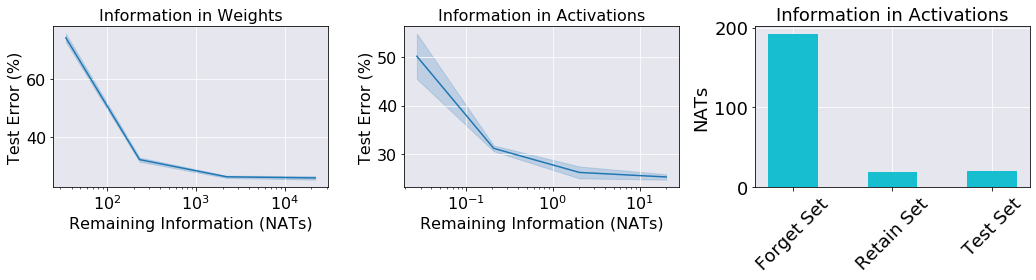

In [229]:
fig, ax = plt.subplots(1,3,figsize=(1+3*4.5,4))
plot_info(ax[0],df,None,'Information in Weights',True)
plot_info(ax[1],df_act,None,'Information in Activations',True)
plot_info(ax[2],None,information_list,'Information in Activations',False)
fig.tight_layout()
fig.savefig('Plots/information.pdf', format='pdf', bbox_inches='tight')

### Finetune

In [230]:
model_ft = copy.deepcopy(model)
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.batch_size, shuffle=True)    
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

In [231]:
finetune_D_r_activations,finetune_D_r_predictions=activations_predictions(model_ft,retain_loader,'Finetune_D_r')
finetune_D_f_activations,finetune_D_f_predictions=activations_predictions(model_ft,forget_loader,'Finetune_D_f')
finetune_D_t_activations,finetune_D_t_predictions=activations_predictions(model_ft,test_loader_full,'Finetune_D_t')

Finetune_D_r -> Loss:0.035, Error:0.0
Finetune_D_f -> Loss:0.068, Error:0.0
Finetune_D_t -> Loss:0.765, Error:0.246


In [232]:
predictions_distance(m0_D_f_predictions,finetune_D_f_predictions,'Retrain_Finetune_D_f')
activations_distance(m0_D_f_activations,finetune_D_f_activations,'Retrain_Finetune_D_f')
activations_distance(m0_D_r_activations,finetune_D_r_activations,'Retrain_Finetune_D_r')
activations_distance(m0_D_t_activations,finetune_D_t_activations,'Retrain_Finetune_D_t')

Predictions Distance Retrain_Finetune_D_f -> 9.0
Activations Distance Retrain_Finetune_D_f -> 0.7553855180740356
Activations Distance Retrain_Finetune_D_r -> 0.023555029183626175
Activations Distance Retrain_Finetune_D_t -> 0.08928284794092178


### Readouts

In [256]:
try: readouts
except: readouts = {}

thresh=log_dict['Original_Model_D_f_loss']+1e-5    
readouts["e"] = all_readouts(copy.deepcopy(model),thresh,'Original')
readouts["a"] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune')
readouts["b"] = all_readouts(copy.deepcopy(modelf),thresh,'Fisher')
readouts["c"] = all_readouts(copy.deepcopy(model_scrub),thresh,'NTK')
readouts["c"] = all_readouts(copy.deepcopy(model_scrubf),thresh,'NTK_Fisher')
readouts["d"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain')

Original ->	Full test error: 24.00%	Forget error: 0.00%	Retain error: 0.00%	Fine-tune time: 1 steps


Finetune ->	Full test error: 24.60%	Forget error: 0.00%	Retain error: 0.00%	Fine-tune time: 1 steps


Fisher ->	Full test error: 31.00%	Forget error: 12.00%	Retain error: 15.16%	Fine-tune time: 20 steps


NTK ->	Full test error: 25.40%	Forget error: 28.00%	Retain error: 0.00%	Fine-tune time: 64 steps


NTK_Fisher ->	Full test error: 25.40%	Forget error: 28.00%	Retain error: 0.00%	Fine-tune time: 64 steps


Retrain ->	Full test error: 25.60%	Forget error: 36.00%	Retain error: 0.00%	Fine-tune time: 64 steps


# Save Dictionary

In [794]:
np.save(f"logs/{m0_name.split('/')[1].split('.')[0]}.npy",log_dict)

### Activations along the path

##### Membership Attack

In [796]:
from sklearn.svm import SVC

def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):
    
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)
    prob = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    clf = SVC(C=3,gamma='auto',kernel='rbf')
    #clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    return results.mean()
    
def plot_entropy_dist(model, ax, title):
    train_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=100, seed=0, augment=False, shuffle=False)
    indexes = np.flatnonzero(np.array(train_loader_full.dataset.targets) == class_to_forget)
    replaced = np.random.RandomState(0).choice(indexes, size=100 if num_to_forget==100 else len(indexes), replace=False)
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(train_loader_full, test_loader_full, model, replaced)
    sns.distplot(np.log(X_r[Y_r==1]).reshape(-1), kde=False, norm_hist=True, rug=False, label='retain', ax=ax)
    sns.distplot(np.log(X_r[Y_r==0]).reshape(-1), kde=False, norm_hist=True, rug=False, label='test', ax=ax)
    sns.distplot(np.log(X_f).reshape(-1), kde=False, norm_hist=True, rug=False, label='forget', ax=ax)
    ax.legend(prop={'size': 14})
    ax.tick_params(labelsize=12)
    ax.set_title(title,size=18)
    ax.set_xlabel('Log of Entropy',size=14)
    ax.set_ylim(0,0.4)
    ax.set_xlim(-35,2)

def membership_attack(retain_loader,forget_loader,test_loader,model):
    prob = get_membership_attack_prob(retain_loader,forget_loader,test_loader,model)
    print("Attack prob: ", prob)
    return prob

In [797]:
attack_dict={}

In [798]:
attack_dict['Original']=membership_attack(retain_loader,forget_loader,test_loader_full,model)

Attack prob:  1.0


In [799]:
attack_dict['Retrain']=membership_attack(retain_loader,forget_loader,test_loader_full,model0)

Attack prob:  0.8


In [800]:
attack_dict['NTK']=membership_attack(retain_loader,forget_loader,test_loader_full,model_scrub)

Attack prob:  0.8


In [801]:
attack_dict['Fisher']=membership_attack(retain_loader,forget_loader,test_loader_full,modelf)

Attack prob:  1.0


In [802]:
attack_dict['Finetune']=membership_attack(retain_loader,forget_loader,test_loader_full,model_ft)

Attack prob:  0.96


In [803]:
attack_dict['Fisher_NTK']=membership_attack(retain_loader,forget_loader,test_loader_full,model_scrubf)

Attack prob:  0.8
